In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
import tensorflow as tf
import pathlib
from tensorflow import keras
from keras.layers import Dense,Reshape,Flatten,Input,Conv2D,Concatenate,Lambda,BatchNormalization,ReLU,Conv1D,DepthwiseConv1D
from keras.callbacks import TensorBoard , ModelCheckpoint
import sklearn  
import pickle

# import wandb
# from wandb.keras import WandbCallback
# wandb.init(project="five-min-project", entity="slick-team")

mpl.rcParams['figure.figsize'] = (12, 8)
mpl.rcParams['axes.grid'] = False

In [15]:
#GETTING DATA

df = pd.read_csv('data/sp500_with_indicators.csv')
date_time = pd.to_datetime(df.pop('DateTime'))
timestamp_s = date_time.map(pd.Timestamp.timestamp)

#Removing unnecessary columns
CLOSE = df.pop('Close')
OPEN = df.pop('Open') 
HIGH = df.pop('High') 
LOW = df.pop('Low') 
VOLUME = df.pop('Volume') 
SPREAD = df.pop('Spread')
TICKVOL = df.pop('TickVol') 
BUY_OR_SELL = df.pop('Class')
BUY_OR_SELL_NUMBER = df.pop('Class_Number')


BUY_OR_SELL

0         Sell
1         Sell
2         Sell
3         Sell
4         Sell
          ... 
103062     Buy
103063     Buy
103064     Buy
103065     Buy
103066     Buy
Name: Class, Length: 103067, dtype: object

In [10]:
#DATA PROCESSING CLASS

class DataProcessing():

    def __init__(self ,data:pd.core.frame.DataFrame , output:pd.core.series.Series , input_width:int, stockname:str,
                    min_max :bool =False,minimum:float=1.0 , maximum:float=1.0):
        """init method of our DataProcessing class

        Args:
            data (pd.core.frame.DataFrame): all of our data
            output (pd.core.series.Series): all of our outputs
            input_width (int): window size
            stockname (str): stock name 
            min_max (bool, optional):  wether we want min_max scaling.Defaults to False.
            minimum (float, optional): mininum of scaled data. Defaults to 1.0.
            maximum (float, optional): maximum of scaled data. Defaults to 1.0.
        """
        self.stockname :str  = stockname 
        self.input_width : int = input_width
        self.data :pd.core.frame.DataFrame = data
        self.output : pd.core.series.Series = output
        self.column_indices : list[str] = {name: i for i, name in enumerate(data.columns)}
        self.num_features : int = data.shape[1]
        
        self.data_mean = self.data.mean()
        self.data_std = self.data.std()
        #slit into test and train data
        # n = len(data)

        # self.input_train_dataset = data[:int(0.90 * n)]
        # self.output_train_dataset = output[:int(0.90 * n)]


        # self.input_test_dataset = data[int(0.90 * n):]
        # self.output_test_dataset = output[int(0.90 * n):]


        #reset indecies
        # self.input_test_dataset = self.input_test_dataset.reset_index()
        # self.input_test_dataset.pop("index")
        
        # self.output_test_dataset = self.output_test_dataset.reset_index()
        # self.output_test_dataset = self.output_test_dataset["Class_Number"]

        #Normalizing The Data

        # self.input_train_dataset, self.input_train_std ,self.input_train_mean = normalize(self.input_train_dataset)
        # self.input_test_dataset ,_,_ = normalize(self.input_test_dataset,data_std=self.input_train_std,data_mean=self.input_train_mean)


        # self.input_train_std = self.input_train_dataset.std()  
        # self.input_train_mean = self.input_train_dataset.mean()
        
        # self.input_train_dataset = (self.input_train_dataset - self.input_train_mean) / self.input_train_std
        # self.input_test_dataset = (self.input_test_dataset - self.input_train_mean) / self.input_train_std

        #Min max scaling 

        # if(min_max):
        #     self.input_train_dataset = min_max_scaler(self.input_train_dataset,minimum,maximum)
        #     self.input_test_dataset = min_max_scaler(self.input_test_dataset,minimum,maximum)
            

    def plot_normalized_data(self):
        data_std = (self.data - self.data_mean) / self.data_std
        data_std = data_std.melt(var_name="Column", value_name="Normalized")
        plt.figure(figsize=(40, 12))
        ax = sns.violinplot(x="Column", y="Normalized", data=data_std)
        _ = ax.set_xticklabels(self.data.keys(), rotation=90)

    def make_windows(self,input_data:pd.core.frame.DataFrame , output_data:pd.core.series.Series , convert_to_numpy:bool = True):
        
        """making windows

        Args:
            input_data (pd.core.frame.DataFrame): input data
            output_data (pd.core.series.Series): output data
            convert_to_numpy (bool, optional): whether we want to convert our windows to numpy or not. Defaults to True.

        Returns:
            2 lists/numpy arrays: input windows and output windows
        """
        
        window_input = []
        window_output=[]

        for i in range(self.input_width,len(input_data)+1):

            window_input.append(input_data[i-self.input_width:i].reset_index())
            
            window_output.append(output_data[i-1])

            window_input[-1].pop("index")
            
            #convert pd.DataFrame to numpy
            window_input[-1]= window_input[-1].to_numpy() 

        #convert list to numpy

        if(convert_to_numpy):
            window_input = np.asarray(window_input)
            window_output = np.asarray(window_output)

            window_output = tf.one_hot(window_output,depth=2)

        return window_input,window_output  


def normalize(data:pd.core.frame.DataFrame,data_std=None,data_mean=None):
    if(data_std is None):
        data_std = data.std()
    if(data_mean is None):
        data_mean = data.mean()


    data_normalized = (data-data_mean)/data_std

    return data_normalized, data_std,data_mean
    
def min_max_scaler(data:pd.core.frame.DataFrame,minimum:float,maximum:float):
    data_max = data.describe().transpose()["max"]
    data_min = data.describe().transpose()["min"]
    data_std = (data-data_min)/(data_max-data_min)
    data_scaled = data_std*(abs(minimum)+maximum)+minimum
    return data_scaled


In [11]:
data = DataProcessing(  data=df,
                        output=BUY_OR_SELL_NUMBER,
                        input_width=256,
                        stockname="sp500_with_Indicator",
                        min_max=True,
                        minimum=-1.0,
                        maximum=1.0
                        )


In [12]:
scaled_data ,_,_=normalize(df)

scaled_df = min_max_scaler(scaled_data,-1.,1.)


In [13]:
#MAKE, SAVE, LOAD
def make():
    input_window , output_window = data.make_windows(   
                                                    input_data=scaled_df,
                                                    output_data=BUY_OR_SELL_NUMBER,
                                                    convert_to_numpy=False
                                                )
    return input_window,output_window

def save(input_window,output_window):
    with open("data/windows/input_window.pickle","wb") as fp:
        pickle.dump(input_window,fp)

    with open('data/windows/output_window.pickle','wb') as fp:
        pickle.dump(output_window,fp)


def load():
    with open('data/windows/input_window.pickle','rb') as fp:
        input_window=pickle.load(fp)

    with open('data/windows/output_window.pickle','rb') as fp:
        output_window=pickle.load(fp)
    return input_window,output_window

input_window,output_window=make()
# save(input_window,output_window)
# input_window,output_window=load()


In [16]:
#MAKE, SAVE and LOAD train/test  
def make_train_test(input_window,output_window):

    test_input = []
    test_output = []

    test_input_24 = []
    test_output_24 = []

    random_indices = []

    for j in range(200):

        random_index=np.random.randint(0,len(input_window)-48)
        random_indices.append(random_index)
        inp = []
        out = []

        for i in range(48):
            index=i+random_index
            
            inp.append(input_window.pop(index))
            out.append(output_window.pop(index))

        for i in range(24):
            test_input_24.append(inp[i])
            test_output_24.append(out[i])

            test_input.append(inp[i+24])
            test_output.append(out[i+24])


    #CONVERT TO NUMPY
    input_window = np.asarray(input_window)
    output_window = np.asarray(output_window)
    output_window = tf.one_hot(output_window,depth=2)

    test_input = np.asarray(test_input)
    test_output = np.asarray(test_output)
    test_output = tf.one_hot(test_output,depth=2)

    test_input_24 = np.asarray(test_input_24)
    test_output_24 = np.asarray(test_output_24)
    test_output_24 = tf.one_hot(test_output_24,depth=2)

    return input_window,output_window,test_input,test_output,test_input_24,test_output_24,random_indices


def save_train_test(input_window,output_window,test_input,test_output,test_input_24,test_output_24,random_indices):

        with open('data/windows/train_data/input_window.pickle','wb') as fp:
            pickle.dump(input_window,fp)

        with open('data/windows/train_data/output_window.pickle','wb') as fp:
            pickle.dump(output_window,fp)

        with open('data/windows/test_data/test_input.pickle','wb') as fp:
            pickle.dump(test_input,fp)

        with open('data/windows/test_data/test_output.pickle','wb') as fp:
            pickle.dump(test_output,fp)

        with open('data/windows/test_data/test_input_24.pickle','wb') as fp:
            pickle.dump(test_input_24,fp)

        with open('data/windows/test_data/test_output_24.pickle','wb') as fp:
            pickle.dump(test_output_24,fp)

        with open('data/windows/test_data/random_indices.pickle','wb') as fp:
            pickle.dump(random_indices,fp)


def load_train_test():

    with open('data/windows/train_data/input_window.pickle','rb') as fp:
        input_window=pickle.load(fp)

    with open('data/windows/train_data/output_window.pickle','rb') as fp:
        output_window=pickle.load(fp)

    with open('data/windows/test_data/test_input.pickle','rb') as fp:
        test_input=pickle.load(fp)

    with open('data/windows/test_data/test_output.pickle','rb') as fp:
        test_output=pickle.load(fp)

    with open('data/windows/test_data/test_input_24.pickle','rb') as fp:
        test_input_24=pickle.load(fp)

    with open('data/windows/test_data/test_output_24.pickle','rb') as fp:
        test_output_24=pickle.load(fp)

    with open('data/windows/test_data/random_indices.pickle','rb') as fp:
        random_indices=pickle.load(fp)

    return input_window,output_window,test_input,test_output,test_input_24,test_output_24,random_indices
        
input_window,output_window,test_input,test_output,test_input_24,test_output_24,random_indices = make_train_test(input_window,output_window)
save_train_test(input_window,output_window,test_input,test_output,test_input_24,test_output_24,random_indices)
# input_window,output_window,test_input,test_output,test_input_24,test_output_24,random_indices = load_train_test()

In [17]:
def compile_and_fit(model,modelname,data:DataProcessing,input_window,output_window ,modelcheckpoint:bool = False):
    import os

    MAX_EPOCHS = 10
    # wandb.config = {
    #         "learning_rate": 0.001,
    #         "epochs": MAX_EPOCHS,
    #         "batch_size": 64
    #         }


    #check if path is available
    path = f'models/{modelname}/{data.stockname}/tensorboard/logs/fit'
    pathlib.Path(path).mkdir(parents=True,exist_ok=True)

    #tensorboard
    log_dir =f'models/{modelname}/{data.stockname}/tensorboard/logs/fit/{datetime.datetime.now().strftime("(%Y-%m-%d)-(%H-%M-%S)")}'
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    #modelcheckpoint
    checkpoint_path = "tmp/cp-{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_binary_accuracy',
        verbose=1,
        save_weights_only=True,
        save_best_only=False
    )

    model.save_weights(checkpoint_path.format(epoch=0))


    model.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=[tf.metrics.BinaryAccuracy()])

    if modelcheckpoint:
        history = model.fit(    x=input_window,
                                y= output_window,
                                validation_data=(test_input,test_output),
                                batch_size=64,
                                shuffle=True,
                                epochs=MAX_EPOCHS,
                                verbose=2,
                                callbacks=[tensorboard_callback,model_checkpoint_callback],
                            )

    else:
        
        history = model.fit(    
                        x=input_window,
                        y= output_window,
                        validation_data=(test_input,test_output),
                        batch_size=64,
                        shuffle=True,
                        epochs=MAX_EPOCHS,
                        verbose=2,
                        callbacks=[tensorboard_callback],
                    )
    
    return history

In [19]:
def convert_candle_to_1d_array(candles_reshape,filters):

    conv2d_1 = Conv2D(filters=filters/1,kernel_size=(  4,3),strides=(2,1),name="conv2d_1")(candles_reshape)
    conv2d_2 = Conv2D(filters=filters/2,kernel_size=(  8,3),strides=(2,1),name="conv2d_2")(candles_reshape)
    conv2d_3 = Conv2D(filters=filters/3,kernel_size=( 16,3),strides=(2,1),name="conv2d_3")(candles_reshape)
    conv2d_4 = Conv2D(filters=filters/4,kernel_size=( 32,3),strides=(2,1),name="conv2d_4")(candles_reshape)
    conv2d_5 = Conv2D(filters=filters/5,kernel_size=( 64,3),strides=(2,1),name="conv2d_5")(candles_reshape)
    conv2d_6 = Conv2D(filters=filters/6,kernel_size=(128,3),strides=(2,1),name="conv2d_6")(candles_reshape)

    batch_norm_1 = BatchNormalization(name="batch_norm_1")(conv2d_1)
    batch_norm_2 = BatchNormalization(name="batch_norm_2")(conv2d_2)
    batch_norm_3 = BatchNormalization(name="batch_norm_3")(conv2d_3)
    batch_norm_4 = BatchNormalization(name="batch_norm_4")(conv2d_4)
    batch_norm_5 = BatchNormalization(name="batch_norm_5")(conv2d_5)
    batch_norm_6 = BatchNormalization(name="batch_norm_6")(conv2d_6)

    relu_1 = ReLU(name = "relu_1")(batch_norm_1)
    relu_2 = ReLU(name = "relu_2")(batch_norm_2)
    relu_3 = ReLU(name = "relu_3")(batch_norm_3)
    relu_4 = ReLU(name = "relu_4")(batch_norm_4)
    relu_5 = ReLU(name = "relu_5")(batch_norm_5)
    relu_6 = ReLU(name = "relu_6")(batch_norm_6)

    reshape_1 = Reshape(target_shape=(relu_1.shape[1],relu_1.shape[3]),name='reshape_1')(relu_1)
    reshape_2 = Reshape(target_shape=(relu_2.shape[1],relu_2.shape[3]),name='reshape_2')(relu_2)
    reshape_3 = Reshape(target_shape=(relu_3.shape[1],relu_3.shape[3]),name='reshape_3')(relu_3)
    reshape_4 = Reshape(target_shape=(relu_4.shape[1],relu_4.shape[3]),name='reshape_4')(relu_4)
    reshape_5 = Reshape(target_shape=(relu_5.shape[1],relu_5.shape[3]),name='reshape_5')(relu_5)
    reshape_6 = Reshape(target_shape=(relu_6.shape[1],relu_6.shape[3]),name='reshape_6')(relu_6)

    return reshape_1,reshape_2,reshape_3,reshape_4,reshape_5,reshape_6

def one_stride_conv_block(reshape_1,reshape_2,reshape_3,reshape_4,reshape_5,reshape_6,filters , blockid:int):

    depthwiseconv1d_1 = DepthwiseConv1D(kernel_size=  4 ,padding='same',name=f'depthconv1d_1_block{blockid}')(reshape_1)
    depthwiseconv1d_2 = DepthwiseConv1D(kernel_size=  8 ,padding='same',name=f'depthconv1d_2_block{blockid}')(reshape_2)
    depthwiseconv1d_3 = DepthwiseConv1D(kernel_size= 16 ,padding='same',name=f'depthconv1d_3_block{blockid}')(reshape_3)
    depthwiseconv1d_4 = DepthwiseConv1D(kernel_size= 32 ,padding='same',name=f'depthconv1d_4_block{blockid}')(reshape_4)
    depthwiseconv1d_5 = DepthwiseConv1D(kernel_size= 64 ,padding='same',name=f'depthconv1d_5_block{blockid}')(reshape_5)
    depthwiseconv1d_6 = DepthwiseConv1D(kernel_size=128 ,padding='same',name=f'depthconv1d_6_block{blockid}')(reshape_6)

    batch_norm_1 = BatchNormalization(name=f'batch_norm_1_1_block{blockid}')(depthwiseconv1d_1)
    batch_norm_2 = BatchNormalization(name=f'batch_norm_1_2_block{blockid}')(depthwiseconv1d_2)
    batch_norm_3 = BatchNormalization(name=f'batch_norm_1_3_block{blockid}')(depthwiseconv1d_3)
    batch_norm_4 = BatchNormalization(name=f'batch_norm_1_4_block{blockid}')(depthwiseconv1d_4)
    batch_norm_5 = BatchNormalization(name=f'batch_norm_1_5_block{blockid}')(depthwiseconv1d_5)
    batch_norm_6 = BatchNormalization(name=f'batch_norm_1_6_block{blockid}')(depthwiseconv1d_6)

    relu_1 = ReLU(name=f'relu_1_1_block{blockid}')(batch_norm_1)
    relu_2 = ReLU(name=f'relu_1_2_block{blockid}')(batch_norm_2)
    relu_3 = ReLU(name=f'relu_1_3_block{blockid}')(batch_norm_3)
    relu_4 = ReLU(name=f'relu_1_4_block{blockid}')(batch_norm_4)
    relu_5 = ReLU(name=f'relu_1_5_block{blockid}')(batch_norm_5)
    relu_6 = ReLU(name=f'relu_1_6_block{blockid}')(batch_norm_6)

    conv1d_1 = Conv1D(filters=filters/1,kernel_size=  4 ,padding='same',name=f'conv1d_1_block{blockid}')(relu_1)
    conv1d_2 = Conv1D(filters=filters/2,kernel_size=  8 ,padding='same',name=f'conv1d_2_block{blockid}')(relu_2)
    conv1d_3 = Conv1D(filters=filters/3,kernel_size= 16 ,padding='same',name=f'conv1d_3_block{blockid}')(relu_3)
    conv1d_4 = Conv1D(filters=filters/4,kernel_size= 32 ,padding='same',name=f'conv1d_4_block{blockid}')(relu_4)
    conv1d_5 = Conv1D(filters=filters/5,kernel_size= 64 ,padding='same',name=f'conv1d_5_block{blockid}')(relu_5)
    conv1d_6 = Conv1D(filters=filters/6,kernel_size=128 ,padding='same',name=f'conv1d_6_block{blockid}')(relu_6)

    batch_norm_1 = BatchNormalization(name=f'batch_norm_2_1_block{blockid}')(conv1d_1)
    batch_norm_2 = BatchNormalization(name=f'batch_norm_2_2_block{blockid}')(conv1d_2)
    batch_norm_3 = BatchNormalization(name=f'batch_norm_2_3_block{blockid}')(conv1d_3)
    batch_norm_4 = BatchNormalization(name=f'batch_norm_2_4_block{blockid}')(conv1d_4)
    batch_norm_5 = BatchNormalization(name=f'batch_norm_2_5_block{blockid}')(conv1d_5)
    batch_norm_6 = BatchNormalization(name=f'batch_norm_2_6_block{blockid}')(conv1d_6)

    relu_1 = ReLU(name=f'relu_2_1_block{blockid}')(batch_norm_1)
    relu_2 = ReLU(name=f'relu_2_2_block{blockid}')(batch_norm_2)
    relu_3 = ReLU(name=f'relu_2_3_block{blockid}')(batch_norm_3)
    relu_4 = ReLU(name=f'relu_2_4_block{blockid}')(batch_norm_4)
    relu_5 = ReLU(name=f'relu_2_5_block{blockid}')(batch_norm_5)
    relu_6 = ReLU(name=f'relu_2_6_block{blockid}')(batch_norm_6)

    return relu_1,relu_2,relu_3,relu_4,relu_5,relu_6

def two_stride_conv_block(relu_1,relu_2,relu_3,relu_4,relu_5,relu_6,filters:int,blockid:int):

    depthwiseconv1d_1 = DepthwiseConv1D(kernel_size=  4 ,padding='same',strides= 2,name=f'depthconv1d_1_block{blockid}')(relu_1)
    depthwiseconv1d_2 = DepthwiseConv1D(kernel_size=  8 ,padding='same',strides= 2,name=f'depthconv1d_2_block{blockid}')(relu_2)
    depthwiseconv1d_3 = DepthwiseConv1D(kernel_size= 16 ,padding='same',strides= 2,name=f'depthconv1d_3_block{blockid}')(relu_3)
    depthwiseconv1d_4 = DepthwiseConv1D(kernel_size= 32 ,padding='same',strides= 2,name=f'depthconv1d_4_block{blockid}')(relu_4)
    depthwiseconv1d_5 = DepthwiseConv1D(kernel_size= 64 ,padding='same',strides= 2,name=f'depthconv1d_5_block{blockid}')(relu_5)
    depthwiseconv1d_6 = DepthwiseConv1D(kernel_size=128 ,padding='same',strides= 2,name=f'depthconv1d_6_block{blockid}')(relu_6)

    batch_norm_1 = BatchNormalization(name=f'batch_norm_1_1_block{blockid}')(depthwiseconv1d_1)
    batch_norm_2 = BatchNormalization(name=f'batch_norm_1_2_block{blockid}')(depthwiseconv1d_2)
    batch_norm_3 = BatchNormalization(name=f'batch_norm_1_3_block{blockid}')(depthwiseconv1d_3)
    batch_norm_4 = BatchNormalization(name=f'batch_norm_1_4_block{blockid}')(depthwiseconv1d_4)
    batch_norm_5 = BatchNormalization(name=f'batch_norm_1_5_block{blockid}')(depthwiseconv1d_5)
    batch_norm_6 = BatchNormalization(name=f'batch_norm_1_6_block{blockid}')(depthwiseconv1d_6)

    relu_1 = ReLU(name=f'relu_1_1_block{blockid}')(batch_norm_1)
    relu_2 = ReLU(name=f'relu_1_2_block{blockid}')(batch_norm_2)
    relu_3 = ReLU(name=f'relu_1_3_block{blockid}')(batch_norm_3)
    relu_4 = ReLU(name=f'relu_1_4_block{blockid}')(batch_norm_4)
    relu_5 = ReLU(name=f'relu_1_5_block{blockid}')(batch_norm_5)
    relu_6 = ReLU(name=f'relu_1_6_block{blockid}')(batch_norm_6)

    conv1d_1 = Conv1D(filters=filters/1,kernel_size=  4 ,padding='same',name=f'conv1d_1_block{blockid}')(relu_1)
    conv1d_2 = Conv1D(filters=filters/2,kernel_size=  8 ,padding='same',name=f'conv1d_2_block{blockid}')(relu_2)
    conv1d_3 = Conv1D(filters=filters/3,kernel_size= 16 ,padding='same',name=f'conv1d_3_block{blockid}')(relu_3)
    conv1d_4 = Conv1D(filters=filters/4,kernel_size= 32 ,padding='same',name=f'conv1d_4_block{blockid}')(relu_4)
    conv1d_5 = Conv1D(filters=filters/5,kernel_size= 64 ,padding='same',name=f'conv1d_5_block{blockid}')(relu_5)
    conv1d_6 = Conv1D(filters=filters/6,kernel_size=128 ,padding='same',name=f'conv1d_6_block{blockid}')(relu_6)

    batch_norm_1 = BatchNormalization(name=f'batch_norm_2_1_block{blockid}')(conv1d_1)
    batch_norm_2 = BatchNormalization(name=f'batch_norm_2_2_block{blockid}')(conv1d_2)
    batch_norm_3 = BatchNormalization(name=f'batch_norm_2_3_block{blockid}')(conv1d_3)
    batch_norm_4 = BatchNormalization(name=f'batch_norm_2_4_block{blockid}')(conv1d_4)
    batch_norm_5 = BatchNormalization(name=f'batch_norm_2_5_block{blockid}')(conv1d_5)
    batch_norm_6 = BatchNormalization(name=f'batch_norm_2_6_block{blockid}')(conv1d_6)

    relu_1 = ReLU(name=f'relu_2_1_block{blockid}')(batch_norm_1)
    relu_2 = ReLU(name=f'relu_2_2_block{blockid}')(batch_norm_2)
    relu_3 = ReLU(name=f'relu_2_3_block{blockid}')(batch_norm_3)
    relu_4 = ReLU(name=f'relu_2_4_block{blockid}')(batch_norm_4)
    relu_5 = ReLU(name=f'relu_2_5_block{blockid}')(batch_norm_5)
    relu_6 = ReLU(name=f'relu_2_6_block{blockid}')(batch_norm_6)

    return relu_1,relu_2,relu_3,relu_4,relu_5,relu_6


In [20]:
#candle MODEL

input_layer = Input(shape=(256,3))
reshaped_candles = Reshape(target_shape=(256,3,1),name="reshape_0")(input_layer)
#Converting candles into 1d arrays

reshape_1,reshape_2,reshape_3,reshape_4,reshape_5,reshape_6 = convert_candle_to_1d_array(
                                                                                            candles_reshape=reshaped_candles,
                                                                                            filters=32
                                                                                        )

#Block1 with strides = 1, shape sizes of: 127 , 125 , 121 , 113 , 97 , 65 

relu_1,relu_2,relu_3,relu_4,relu_5,relu_6 = one_stride_conv_block(
                                                                    reshape_1,
                                                                    reshape_2,
                                                                    reshape_3,
                                                                    reshape_4,
                                                                    reshape_5,
                                                                    reshape_6,
                                                                    filters=32,
                                                                    blockid=1
                                                                )


#Block 2 with stride = 2, shape sizes of: 64 , 63 , 61 , 57 , 49 , 33
relu_1,relu_2,relu_3,relu_4,relu_5,relu_6 = two_stride_conv_block(
                                                                    relu_1,
                                                                    relu_2,
                                                                    relu_3,
                                                                    relu_4,
                                                                    relu_5,
                                                                    relu_6,
                                                                    filters=64,
                                                                    blockid=2
                                                                )

#Block 3 with stride = 2, shape sizes of: 32 , 32, 31, 29, 25 , 17
relu_1,relu_2,relu_3,relu_4,relu_5,relu_6 = two_stride_conv_block(
                                                                    relu_1,
                                                                    relu_2,
                                                                    relu_3,
                                                                    relu_4,
                                                                    relu_5,
                                                                    relu_6,
                                                                    filters=128,
                                                                    blockid=3
                                                                )

#Block 4 with stride = 2, shape sizes of: 16, 16, 16, 15, 13,  9
relu_1,relu_2,relu_3,relu_4,relu_5,relu_6 = two_stride_conv_block(
                                                                    relu_1,
                                                                    relu_2,
                                                                    relu_3,
                                                                    relu_4,
                                                                    relu_5,
                                                                    relu_6,
                                                                    filters=256,
                                                                    blockid=4
                                                                )

#Block 5 with stride = 2, shape sizes of: 8, 8, 8, 8, 7, 5
relu_1,relu_2,relu_3,relu_4,relu_5,relu_6 = two_stride_conv_block(
                                                                    relu_1,
                                                                    relu_2,
                                                                    relu_3,
                                                                    relu_4,
                                                                    relu_5,
                                                                    relu_6,
                                                                    filters=256,
                                                                    blockid=5
                                                                )


global_avg_pool_1 = keras.layers.GlobalAveragePooling1D(name="global_avg_pool_1")(relu_1)
global_avg_pool_2 = keras.layers.GlobalAveragePooling1D(name="global_avg_pool_2")(relu_2)
global_avg_pool_3 = keras.layers.GlobalAveragePooling1D(name="global_avg_pool_3")(relu_3)
global_avg_pool_4 = keras.layers.GlobalAveragePooling1D(name="global_avg_pool_4")(relu_4)
global_avg_pool_5 = keras.layers.GlobalAveragePooling1D(name="global_avg_pool_5")(relu_5)
global_avg_pool_6 = keras.layers.GlobalAveragePooling1D(name="global_avg_pool_6")(relu_6)


candle_model = keras.Model(
                        inputs = input_layer,

                        outputs = [
                                    global_avg_pool_1,
                                    global_avg_pool_2,
                                    global_avg_pool_3,
                                    global_avg_pool_4,
                                    global_avg_pool_5,
                                    global_avg_pool_6
                                ]
                    )



In [21]:
#INDICATOR MODEL

input_layer = Input(shape=(256,13))

relu_1,relu_2,relu_3,relu_4,relu_5,relu_6 = one_stride_conv_block(
                                                                    input_layer,
                                                                    input_layer,
                                                                    input_layer,
                                                                    input_layer,
                                                                    input_layer,
                                                                    input_layer,
                                                                    filters=32,
                                                                    blockid=10
                                                                )

relu_1,relu_2,relu_3,relu_4,relu_5,relu_6 = one_stride_conv_block(
                                                                    relu_1,
                                                                    relu_2,
                                                                    relu_3,
                                                                    relu_4,
                                                                    relu_5,
                                                                    relu_6,
                                                                    filters=32,
                                                                    blockid=11
                                                                )


#Block 2 with stride = 2, shape sizes of: 64 , 63 , 61 , 57 , 49 , 33
relu_1,relu_2,relu_3,relu_4,relu_5,relu_6 = two_stride_conv_block(
                                                                    relu_1,
                                                                    relu_2,
                                                                    relu_3,
                                                                    relu_4,
                                                                    relu_5,
                                                                    relu_6,
                                                                    filters=64,
                                                                    blockid=12
                                                                )

#Block 3 with stride = 2, shape sizes of: 32 , 32, 31, 29, 25 , 17
relu_1,relu_2,relu_3,relu_4,relu_5,relu_6 = two_stride_conv_block(
                                                                    relu_1,
                                                                    relu_2,
                                                                    relu_3,
                                                                    relu_4,
                                                                    relu_5,
                                                                    relu_6,
                                                                    filters=128,
                                                                    blockid=13
                                                                )

#Block 4 with stride = 2, shape sizes of: 16, 16, 16, 15, 13,  9
relu_1,relu_2,relu_3,relu_4,relu_5,relu_6 = two_stride_conv_block(
                                                                    relu_1,
                                                                    relu_2,
                                                                    relu_3,
                                                                    relu_4,
                                                                    relu_5,
                                                                    relu_6,
                                                                    filters=256,
                                                                    blockid=14
                                                                )

#Block 5 with stride = 2, shape sizes of: 8, 8, 8, 8, 7, 5
relu_1,relu_2,relu_3,relu_4,relu_5,relu_6 = two_stride_conv_block(
                                                                    relu_1,
                                                                    relu_2,
                                                                    relu_3,
                                                                    relu_4,
                                                                    relu_5,
                                                                    relu_6,
                                                                    filters=256,
                                                                    blockid=15
                                                                )


global_avg_pool_1 = keras.layers.GlobalAveragePooling1D(name="global_avg_pool_indicator_1")(relu_1)
global_avg_pool_2 = keras.layers.GlobalAveragePooling1D(name="global_avg_pool_indicator_2")(relu_2)
global_avg_pool_3 = keras.layers.GlobalAveragePooling1D(name="global_avg_pool_indicator_3")(relu_3)
global_avg_pool_4 = keras.layers.GlobalAveragePooling1D(name="global_avg_pool_indicator_4")(relu_4)
global_avg_pool_5 = keras.layers.GlobalAveragePooling1D(name="global_avg_pool_indicator_5")(relu_5)
global_avg_pool_6 = keras.layers.GlobalAveragePooling1D(name="global_avg_pool_indicator_6")(relu_6)


indicator_model = keras.Model(
                        inputs = input_layer,
                        outputs = [
                                    global_avg_pool_1,
                                    global_avg_pool_2,
                                    global_avg_pool_3,
                                    global_avg_pool_4,
                                    global_avg_pool_5,
                                    global_avg_pool_6
                                ]
                    )



In [22]:
#MODEL
input_layer = Input(shape=(256,16))
candles = Lambda(lambda x: x[:,:,-3:])(input_layer)
indicators = Lambda(lambda x: x[:,:,:-3])(input_layer)

gap_candle_1,gap_candle_2,gap_candle_3,gap_candle_4,gap_candle_5,gap_candle_6=candle_model(candles)
gap_indicator_1,gap_indicator_2,gap_indicator_3,gap_indicator_4,gap_indicator_5,gap_indicator_6 = indicator_model(indicators)


concatinate = Concatenate()([   gap_candle_1,
                                gap_candle_2,
                                gap_candle_3,
                                gap_candle_4,
                                gap_candle_5,
                                gap_candle_6,
                                gap_indicator_1,
                                gap_indicator_2,
                                gap_indicator_3,
                                gap_indicator_4,
                                gap_indicator_5,
                                gap_indicator_6]
)

dense01 = Dense(1024 , activation='relu')(concatinate)
output = Dense(2 ,activation='softmax')(dense01)

model = keras.Model(
    inputs = input_layer,
    outputs = output
)



In [23]:
# indicator_model.summary()
# tf.keras.utils.plot_model(model ,'model.png')

In [24]:

#name of the model 
name = "8_(functional_added_macd)_(22_04_18)"


history =compile_and_fit(model=model , modelname=name,
                data = data,input_window=input_window,
                output_window=output_window,modelcheckpoint=True)

Epoch 1/10

Epoch 1: saving model to tmp\cp-0001.ckpt
1457/1457 - 493s - loss: 0.6885 - binary_accuracy: 0.5481 - val_loss: 0.7418 - val_binary_accuracy: 0.5015 - 493s/epoch - 338ms/step
Epoch 2/10

Epoch 2: saving model to tmp\cp-0002.ckpt
1457/1457 - 435s - loss: 0.6426 - binary_accuracy: 0.6260 - val_loss: 0.6882 - val_binary_accuracy: 0.5883 - 435s/epoch - 298ms/step
Epoch 3/10

Epoch 3: saving model to tmp\cp-0003.ckpt
1457/1457 - 418s - loss: 0.5501 - binary_accuracy: 0.7179 - val_loss: 0.9022 - val_binary_accuracy: 0.6069 - 418s/epoch - 287ms/step
Epoch 4/10

Epoch 4: saving model to tmp\cp-0004.ckpt
1457/1457 - 424s - loss: 0.4486 - binary_accuracy: 0.7881 - val_loss: 1.4320 - val_binary_accuracy: 0.5888 - 424s/epoch - 291ms/step
Epoch 5/10

Epoch 5: saving model to tmp\cp-0005.ckpt
1457/1457 - 417s - loss: 0.3721 - binary_accuracy: 0.8316 - val_loss: 0.6297 - val_binary_accuracy: 0.7269 - 417s/epoch - 286ms/step
Epoch 6/10

Epoch 6: saving model to tmp\cp-0006.ckpt
1457/1457 -

In [43]:
# model.save(f'models/{name}/model.h5')

# model = keras.models.load_model(f'models/{name}/model8.h5')
model.load_weights(f"models/{name}/modelcheckpoint/cp-0008.ckpt")
model.save(f'models/{name}/model8.h5')


In [44]:
predicted = model.predict(test_input)
m = tf.keras.metrics.BinaryAccuracy(threshold=0.5)
m.update_state(y_true = test_output,y_pred = predicted)
m.result().numpy()

0.80375

In [42]:
sell=0
buy=0
for i in range(predicted.shape[0]):
    if(predicted[i][0]>.5):
        sell=sell+1
    else:
        buy=buy+1
        
buy

2773

In [ ]:
# a1 = np.ones((3,3),dtype=np.int8) + 0
# a2 = np.ones((3,3),dtype=np.int8) + 1
# a3 = np.ones((3,3),dtype=np.int8) + 2
# a4 = np.ones((3,3),dtype=np.int8) + 3

# a11 = np.ones((3,3),dtype=np.int8) * 10
# a12 = np.ones((3,3),dtype=np.int8) * 20
# a13 = np.ones((3,3),dtype=np.int8) * 30
# a14 = np.ones((3,3),dtype=np.int8) * 40

# inputs = np.array([a1,a2,a3,a4])
# outputs = np.array([a11,a12,a13,a14])
# a , b = sklearn.utils.shuffle(inputs,outputs)
# print(f'{[a123 for a123 in a]},{[b123 for b123 in b]}')


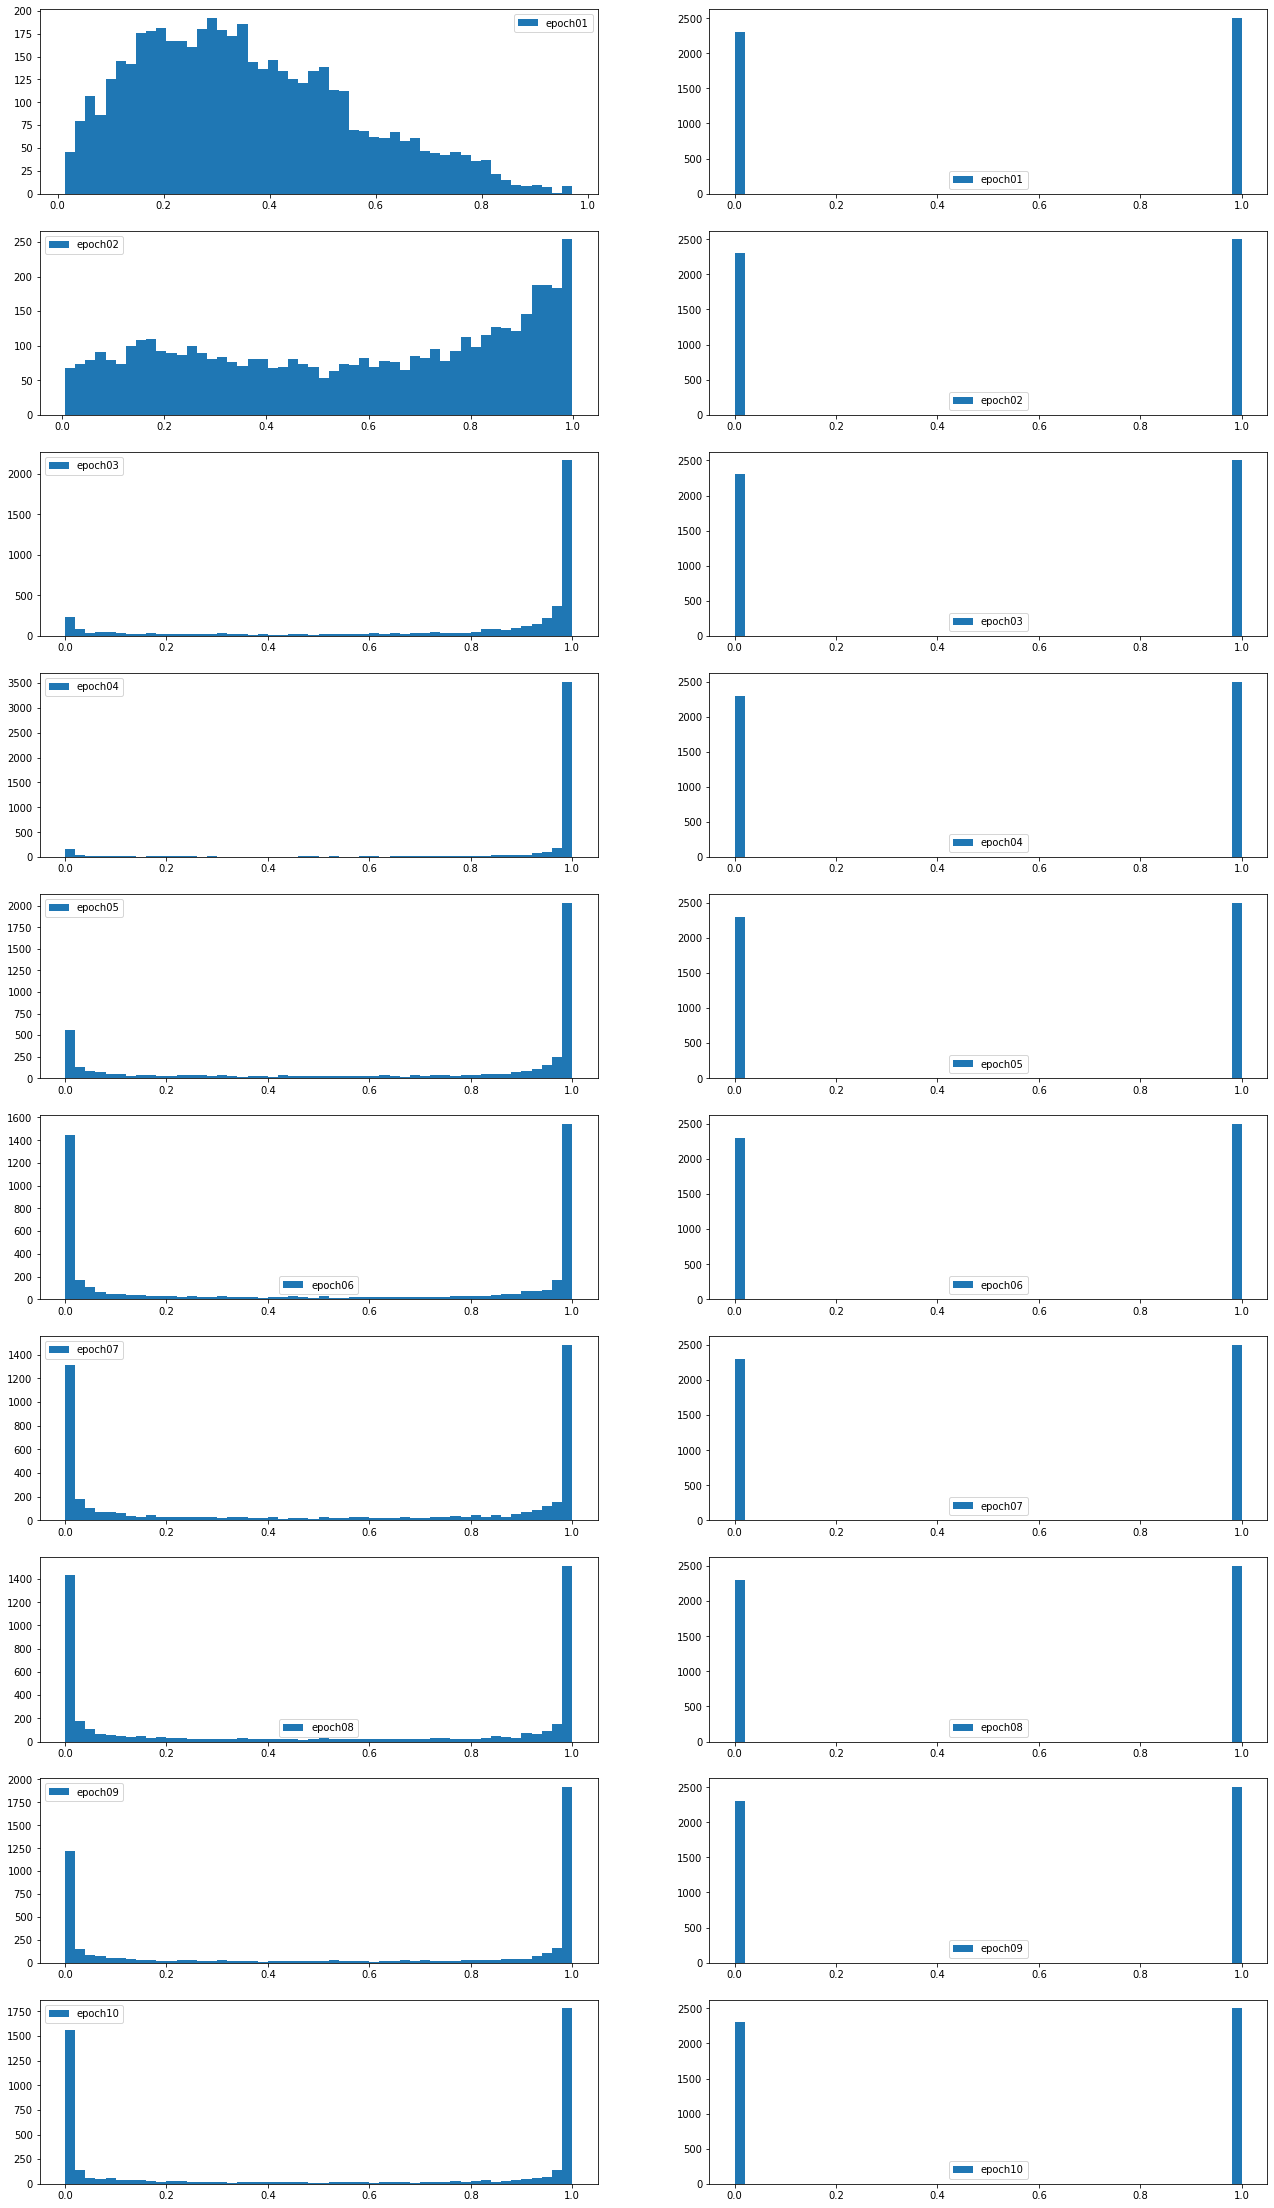

In [26]:
#PLOTING DISTRIBUTION OF PREDICTIONS ON DIFFERENT EPOCHS


predictions = []

NUMBER_OF_EPOCHS=10
model = keras.Model(
                        inputs = input_layer,
                        outputs = output
                    )
for i in range(NUMBER_OF_EPOCHS):

    model.load_weights(f"models/{name}/modelcheckpoint/cp-00{i+1:02d}.ckpt")
    prediction = model.predict(test_input)
    predictions.append(prediction)

#PLOT
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (22, 40)
fig, axes=plt.subplots(10,2)

for i,value in enumerate(predictions):
    for j in range(2):
        if(j==0):
            axes[i,j].hist(value[:,1],bins=50, label=f'epoch{i+1:02d}')
            axes[i,j].legend(loc='best')

        else:
            axes[i,j].hist(test_output[:,1].numpy(),bins=50, label=f'epoch{i+1:02d}')
            axes[i,j].legend(loc='best')

            
